# **Community Prediction and Recommendation on Social Media Data**


In [ ]:
import matplotlib.pyplot as plt
import os
import torch
print("Using torch", torch.__version__)

Using torch 2.1.0+cu118


In [ ]:
!pip install scikit-plot==0.3.7
!pip install torch-geometric
!pip install ogb  # for datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=cc66331037ca1e511dc289c97562f7c84725eb93aa5bcfab3a9854e687f5a684
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
import scikitplot as skplt
from torch_geometric.datasets.snap_dataset import SNAPDataset

## Preprocessing

In [ ]:
from torch_geometric.data import Data
from torch_geometric import nn
import torch_geometric
import torch_geometric.transforms as T

In [ ]:
# train/test/validation split
transform = T.Compose([
    T.RandomLinkSplit(num_val=0.05,  # ratio of edges including in the validation set
                      num_test=0.2,  # ratio of edges including in the test set
                      is_undirected=True,
                      add_negative_train_samples=False),
])

In [ ]:
initial_datasets = SNAPDataset(root='/tmp/SNAPDataset', name='ego-facebook')

# splits all the datasets in the Facebook dataset with the same train/test split
datasets = SNAPDataset(root='/tmp/SNAPDataset', name='ego-facebook', transform=transform)

Extracting /tmp/SNAPDataset/ego-facebook/raw/facebook.tar.gz
Processing...
Done!


In [ ]:
# first graph
data = initial_datasets[0]

# check transform worked correctly
print("Graph 1 Transform")
train_data, val_data, test_data = datasets[0]
print("Number of the nodes in training, validation and test data are", train_data.num_nodes, val_data.num_nodes, test_data.num_nodes)
print("Number of the edges in training, validation and test data are", train_data.num_edges, val_data.num_edges, test_data.num_edges)
print("Number of the edge_label_index in training, validation and test data are", train_data.edge_label_index.shape[1],
                                                                                  val_data.edge_label_index.shape[1],
                                                                                  test_data.edge_label_index.shape[1])

print("Graph 3 Transform")
train_data, val_data, test_data = datasets[2]
print("Number of the nodes in training, validation and test data are", train_data.num_nodes, val_data.num_nodes, test_data.num_nodes)
print("Number of the edges in training, validation and test data are", train_data.num_edges, val_data.num_edges, test_data.num_edges)
print("Number of the edge_label_index in training, validation and test data are", train_data.edge_label_index.shape[1],
                                                                                  val_data.edge_label_index.shape[1],
                                                                                  test_data.edge_label_index.shape[1])

Graph 1 Transform
Number of the nodes in training, validation and test data are 347 347 347
Number of the edges in training, validation and test data are 4292 4292 4576
Number of the edge_label_index in training, validation and test data are 2146 284 1142
Graph 3 Transform
Number of the nodes in training, validation and test data are 792 792 792
Number of the edges in training, validation and test data are 22216 22216 23696
Number of the edge_label_index in training, validation and test data are 11108 1480 5922


In [ ]:
print("Number of nodes and edges in all graphs: ", sum([initial_datasets[i].num_nodes for i in range(10)]), sum([initial_datasets[i].num_edges for i in range(10)]))
print(initial_datasets[0])

Number of nodes and edges in all graphs:  4167 178124
EgoData(x=[347, 1406], edge_index=[2, 5718], circle=[325], circle_batch=[325])


## Basic Graph Info

In [ ]:
def get_n_neighbors(graph, idx):
  # takes a Data object, an index of a node, and returns the number of the neighbors
  # of this node (as an integer).
  return int(torch_geometric.utils.degree(graph.edge_index[0], graph.num_nodes)[idx])

def get_max_degree(graph):
  num_nodes = graph.num_nodes

  degrees = [get_n_neighbors(graph, i) for i in range(num_nodes)]

  return max(degrees)


def get_min_degree(graph):
  num_nodes = graph.num_nodes

  degrees = [get_n_neighbors(graph, i) for i in range(num_nodes)]

  return min(degrees)

In [ ]:
from tabulate import tabulate

tot_nodes = sum([initial_datasets[i].num_nodes for i in range(10)])
tot_edges = sum([initial_datasets[i].num_edges for i in range(10)])
ave_node_degree = 2*tot_edges / tot_nodes
max_node_degree = max([get_max_degree(initial_datasets[i]) for i in range(10)])
min_node_degree = min([get_min_degree(initial_datasets[i]) for i in range(10)])

table = [
    ['Number of nodes: ', tot_nodes],
    ['Number of edges: ', tot_edges],
    ['Average node degree: ', ave_node_degree],
    ['Max node degree', max_node_degree],
    ['Min node degree', min_node_degree],
    ['Number of classes', 0],
    ['Average clustering coefficient', 0.6055],
    ['Number of triangles', 1612010],
    ['Diameter', 8]
]
print("WHOLE FACEBOOK DATASET")
print(tabulate(table))

WHOLE FACEBOOK DATASET
------------------------------  ----------------
Number of nodes:                  4167
Number of edges:                178124
Average node degree:                85.4927
Max node degree                   1044
Min node degree                      1
Number of classes                    0
Average clustering coefficient       0.6055
Number of triangles                  1.61201e+06
Diameter                             8
------------------------------  ----------------


## Edge Prediction with Message-Passing GNN

### Pipeline

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.act = torch.nn.ReLU()

    def forward(self, node_feature, edge_index):

        output = self.conv1(node_feature, edge_index)
        output = self.act(output)
        output = self.conv2(output, edge_index)

        return output

In [ ]:
# initialize GCN
model = GCN(datasets.num_features, hidden_channels=128, out_channels=64)

In [ ]:
# define optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
# define loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

### Negative Sampling

In [ ]:
from torch_geometric.utils import negative_sampling

neg_edge_index = negative_sampling(
      edge_index=train_data.edge_index,  # positive edges in the graph
      num_nodes=train_data.num_nodes,  # number of nodes
      num_neg_samples=5,  # number of negative examples
    )

print("shape of neg_edge_index:", neg_edge_index.shape)  # [2, num_neg_samples]
print("negative examples:", neg_edge_index)

shape of neg_edge_index: torch.Size([2, 5])
negative examples: tensor([[755, 439, 577, 316, 121],
        [ 77,  98,  87, 120, 515]])


### Defining Similarity

In [ ]:
import numpy as np

def compute_similarity(node_embs, edge_index):
    # calculate the inner product between all the pairs in the edge_index
    # Note: the shape of node_embs is [n, h] where n is the number of nodes, and h is the embedding size
    # the shape of edge_index is [2, m] where m is the number of edges

    return torch.sum(node_embs[edge_index[0]] * node_embs[edge_index[1]], dim=1)

n, h = 5, 10  # number of nodes and embedding size
node_embs = torch.rand(n, h)
edge_index = torch.tensor([[0, 1, 2, 3],
                           [2, 3, 0, 1]])  # compute the similarity of (0, 2), (1, 3), (2, 0), (3, 1)
similarity = compute_similarity(node_embs, edge_index)
print("Similarity:", similarity)

Similarity: tensor([3.2926, 3.0549, 3.2926, 3.0549])


### Train and Test

In [ ]:
def train(model, data, optimizer, loss_fn):

    loss = 0

    model.train()
    optimizer.zero_grad()
    node_emb = model(data.x, data.edge_index)
    negative_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_label_index.shape[1]
    )
    labels = torch.cat([torch.ones(data.edge_label_index.shape[1]),torch.zeros(negative_edge_index.shape[1])])
    edge_index = torch.cat([data.edge_label_index, negative_edge_index], dim=1)

    similarity = compute_similarity(node_emb, edge_index)

    LOSS = loss_fn(similarity, labels)
    LOSS.backward()
    optimizer.step()
    loss += LOSS.item()

    return loss

In [ ]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)  # use `edge_index` to perform message passing
    out = compute_similarity(out, data.edge_label_index).view(-1).sigmoid()  # use `edge_label_index` to compute the loss
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [ ]:
epochs = 50

epoch_loss=[]
epoch_val=[]
epoch_test=[]

best_val_auc = final_test_auc = 0
for epoch in range(1, epochs + 1):
    loss = train(model, train_data, optimizer, loss_fn)
    valid_auc = test(model, val_data)
    test_auc = test(model, test_data)
    if valid_auc > best_val_auc:
        best_val_auc = valid_auc
        final_test_auc = test_auc
    if(epoch%5==0):
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_auc:.4f}, Test: {test_auc:.4f}')

    epoch_loss.append(loss)
    epoch_val.append(valid_auc)
    epoch_test.append(test_auc)

Epoch: 005, Loss: 0.6612, Val: 0.8953, Test: 0.8952
Epoch: 010, Loss: 0.5360, Val: 0.8921, Test: 0.8931
Epoch: 015, Loss: 0.5217, Val: 0.8939, Test: 0.8932
Epoch: 020, Loss: 0.5241, Val: 0.8912, Test: 0.8879
Epoch: 025, Loss: 0.5151, Val: 0.8932, Test: 0.8918
Epoch: 030, Loss: 0.5129, Val: 0.8969, Test: 0.8936
Epoch: 035, Loss: 0.5061, Val: 0.9019, Test: 0.8988
Epoch: 040, Loss: 0.5038, Val: 0.9077, Test: 0.9042
Epoch: 045, Loss: 0.4977, Val: 0.9073, Test: 0.9047
Epoch: 050, Loss: 0.4938, Val: 0.9068, Test: 0.9053


### Plots

### Plots

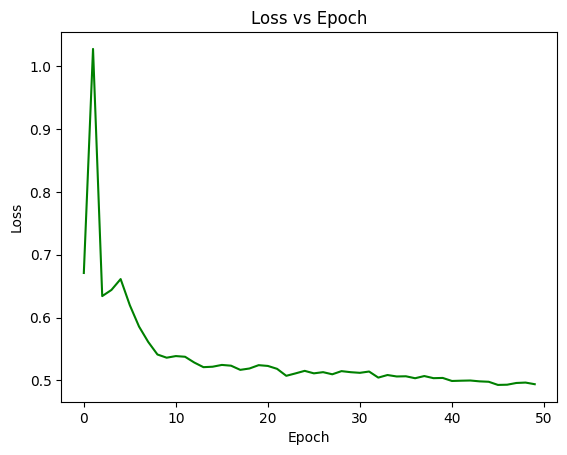

In [ ]:
import matplotlib.pyplot as plt

plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(len(epoch_loss)), epoch_loss, color ="green")
plt.show()

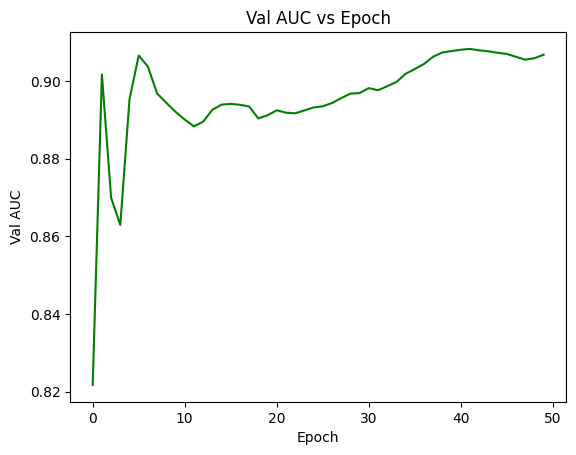

In [ ]:
plt.title("Val AUC vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Val AUC")
plt.plot(range(len(epoch_val)), epoch_val, color ="green")
plt.show()

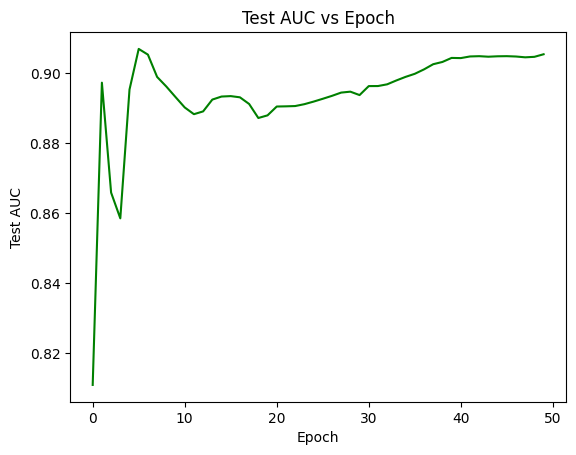

In [ ]:
plt.title("Test AUC vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test AUC")
plt.plot(range(len(epoch_test)), epoch_test, color ="green")
plt.show()

### Evaluation Plots

Source: https://towardsdatascience.com/visualize-machine-learning-metrics-like-a-pro-b0d5d7815065

In [ ]:
node_emb = model(test_data.x, test_data.edge_index)
negative_edge_index = negative_sampling(
        edge_index=test_data.edge_index,
        num_nodes=test_data.num_nodes,
        num_neg_samples=test_data.edge_label_index.shape[1]
)
labels = torch.cat([torch.ones(test_data.edge_label_index.shape[1]),torch.zeros(negative_edge_index.shape[1])])
edge_index = torch.cat([test_data.edge_label_index, negative_edge_index], dim=1)

similarity = compute_similarity(node_emb, edge_index)

print(len(similarity), len(labels))

11844 11844


Now, we use the node embeddings on the test set to get a probability of prediction for each, and make various diagnostic plots for our model

In [ ]:
# make the plots better below by using softmax?
labels = labels

similarity_np = similarity.detach().numpy()

similarity_np = (similarity_np-np.mean(similarity_np))/np.max(similarity_np)
similarity_np = (similarity_np+1)/2
similarity_np_pred = np.rint(similarity_np)

print(similarity_np)

[0.68002766 0.48907608 0.738198   ... 0.44681832 0.5197583  0.6515423 ]


#### Diagnostic Plots

In [ ]:
!pip install scikit-plot==0.3.7
import scikitplot as skplt

In [ ]:
similarity = similarity_np
similarity_pred = similarity_np_pred

<Axes: title={'center': 'Confusion Matrix for GBC'}, xlabel='Predicted label', ylabel='True label'>

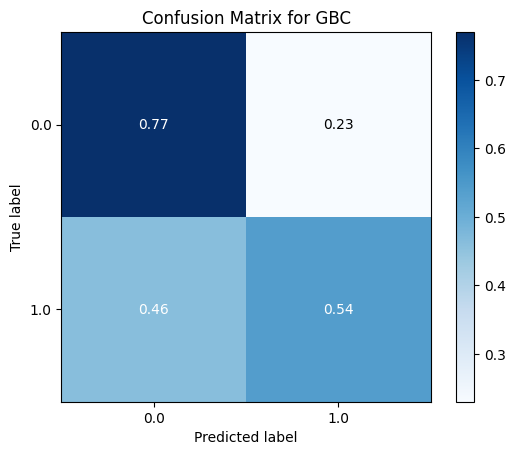

In [ ]:
skplt.metrics.plot_confusion_matrix(labels, similarity_pred, normalize=True, title = 'Confusion Matrix for GBC')